# Hypothesis: Are digitised practices causing more failures?

## Hypothesis

We believe that practices undergoing Lloyd Gerge digitisation have an increased failure rate. 
We will know this to be true when we look at their data for the last three months, and see that either their failures have increased, or that in general their failures are higher than average.

## Context

From the months of May-Aug 2021, we see a steady increase of TPP-->EMIS Large message general failures. A general hypothesis is that this is due to record sizes increasing, which could be due to Lloyd George digitisation. This has prompted a more general hypothesis to identify whether digitisation is impacting failure rates. 

## Scope

- Generate a transfer outcomes table for each of the below CCGs split down for May, June, July:
    - Sunderland
    - Fylde and Wyre
    - Chorley and South Ribble 
    - Blackpool
    - Birmingham and Solihull 
- Show technical failure rate for each month, for each practice in the CCG
- Separate out outcomes for transfers in, and transfers out
- Do this for practices as a sender and as a requester

In [1]:
import pandas as pd
import numpy as np

In [2]:
transfer_file_location = "s3://prm-gp2gp-transfer-data-preprod/v4/"

transfer_files = [
    "2021/5/transfers.parquet",
    "2021/6/transfers.parquet",
    "2021/7/transfers.parquet"
]
transfer_input_files = [transfer_file_location + f for f in transfer_files]

transfers_raw = pd.concat((
    pd.read_parquet(f)
    for f in transfer_input_files
))

transfers = transfers_raw.copy()

In [3]:
asid_lookup_file_location = "s3://prm-gp2gp-asid-lookup-preprod/"
asid_lookup_files = [
    "2021/6/asidLookup.csv.gz",
    "2021/7/asidLookup.csv.gz",
    "2021/8/asidLookup.csv.gz"    
]
asid_lookup_input_files = [asid_lookup_file_location + f for f in asid_lookup_files]
asid_lookup = pd.concat((
    pd.read_csv(f)
    for f in asid_lookup_input_files
)).drop_duplicates()
lookup = asid_lookup[["ASID", "NACS","OrgName"]]

transfers = transfers.merge(lookup, left_on='requesting_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'requesting_supplier_asid', 'NACS': 'requesting_ods_code','OrgName':'requesting_practice_name'}, axis=1)
transfers = transfers.merge(lookup, left_on='sending_practice_asid',right_on='ASID',how='left')
transfers = transfers.rename({'ASID': 'sending_supplier_asid', 'NACS': 'sending_ods_code','OrgName':'sending_practice_name'}, axis=1)

## Generate View of each CCG

In [4]:
# CCG practices copied from practiceMetrics.json - July 2021
ods_codes_to_investigate=dict()
ods_codes_to_investigate['Sunderland']=["A89018", "A89019", "A89036", "A89623", "A89022", "A89001", "A89002", "A89010", "A89020", "A89015", "A89012", "A89028", "A89041", "A89009", "A89004", "A89023", "A89031", "A89617", "A89011", "A89021", "A89017", "A89040", "A89032", "A89026", "A89007", "Y01262", "A89034", "A89008", "A89616", "A89035", "A89027", "A89016", "A89025", "A89614", "A89024", "A89013", "A89005", "A89006", "A89030"]
ods_codes_to_investigate['Fylde and Wyre']=["P81037", "P81129", "P81742", "P81086", "P81157", "P81668", "P81006", "P81059", "P81077", "P81128", "P81149", "P81150", "P81031", "P81191", "P81089", "P81737", "P81087", "P81079", "P81133"]
ods_codes_to_investigate['Chorley and South Ribble']=["P81740", "P81692", "Y02466", "P81117", "P81180", "P81033", "P81701", "Y00347", "P81154", "P81181", "Y03656", "P81044", "P81186", "P81687", "P81062", "P81083", "P81076", "P81741", "P81038", "P81171", "P81082", "P81127", "P81655", "P81143", "P81010", "P81057"]
ods_codes_to_investigate['Blackpool']=["P81714", "P81042", "P81081", "P81115", "P81073", "P81004", "P81072", "P81074", "P81066", "P81054", "P81172", "P81681", "P81043", "P81159", "P81063", "P81092", "P81016"]
ods_codes_to_investigate['Birmingham and Solihull']=["M85736", "M85139", "M85123", "M85149", "Y01068", "M85158", "M89030", "M89013", "M85026", "M85749", "M85779", "M85118", "M89016", "M85766", "M85117", "M85025", "M85159", "M85732", "M85781", "M89008", "M85041", "M85671", "M85113", "M85701", "M88006", "M85642", "M85679", "M85013", "M85048", "M85711", "M85086", "M85029", "M85087", "M85792", "M85680", "M85699", "M89021", "M85097", "M89012", "M89010", "M85717", "M85716", "M85686", "M85065", "M85706", "M85136", "M85128", "M85079", "M85693", "M85116", "M85154", "M85107", "M85051", "M81062", "M85694", "M85170", "M89003", "M89024", "M85670", "M89027", "M85006", "M85735", "Y00159", "Y03597", "M89608", "M85058", "M85043", "M85713", "M85016", "M89019", "Y02567", "M85076", "Y02893", "M85143", "M85088", "M85142", "M85014", "M85037", "M89002", "M85600", "M85155", "M85027", "M85730", "M85028", "M89009", "M85179", "M85063", "M85023", "M85746", "M85733", "M85021", "M85722", "M85759", "M89015", "M85077", "Y02794", "M85078", "M85034", "M85739", "M89001", "M85803", "M85624", "Y02571", "M91642", "M85070", "M89007", "M85172", "M85156", "M85171", "M85110", "M85141", "M85055", "M85042", "M85001", "M85062", "M88020", "M85108", "M89017", "M85756", "M85774", "M85030", "M89005", "M85783", "M85046", "M85115", "M85177", "M85794", "M85174", "M89026", "M85081", "M85031", "M85175", "Y02620", "Y05826", "M85146", "M85024", "M85033", "M85060", "M85005", "M85008", "M85770", "M85053", "M85011", "M85084", "M85669", "M85167", "M85782", "M85753", "M85105", "M85074", "M85066", "M85153", "M85056", "M85134", "M85007", "M85035", "M85047", "M85071", "M85061", "M85094", "M85018"]

In [5]:
def generate_transfer_outcomes(lg_transfers, ods_code_field_name, practice_name_field, supplier_name_field):
    lg_transfers['CCG']=None

    for investigation_group in ods_codes_to_investigate.keys():
        list_lg_practices = ods_codes_to_investigate[investigation_group]
        is_lg_practice_bool = lg_transfers[ods_code_field_name].apply(lambda ods_code: ods_code in list_lg_practices)
        lg_transfers.loc[is_lg_practice_bool,'CCG']=investigation_group

    ccg_practice_bool = pd.notna(lg_transfers["CCG"])
    transfers_of_interest = lg_transfers[ccg_practice_bool].copy()

    transfers_of_interest['Month']=transfers_of_interest['date_requested'].dt.to_period('M')
    transfer_outcomes=pd.pivot_table(transfers_of_interest,index=['Month','CCG',practice_name_field],columns=['status'],values='conversation_id',aggfunc='count')
    transfer_outcomes=transfer_outcomes.fillna(0).astype(int)
    transfer_outcomes["Total transfers"]=transfer_outcomes.sum(axis=1)

    transfer_outcomes_pc=transfer_outcomes.copy()
    transfer_outcomes_pc=(transfer_outcomes_pc.div(transfer_outcomes_pc["Total transfers"],axis=0)*100).round(2)
    transfer_outcomes_pc.columns=transfer_outcomes_pc.columns + " %"
    transfer_outcomes=pd.concat([transfer_outcomes,transfer_outcomes_pc],axis=1)
    transfer_outcomes=transfer_outcomes.drop(columns=["Total transfers %"]).reset_index()
    
    transfer_outcomes[supplier_name_field]=lg_transfers[supplier_name_field]

    return transfer_outcomes

## Generate national transfer outcomes

In [6]:
all_transfers = transfers.copy()

all_transfers['Month']=all_transfers['date_requested'].dt.to_period('M')
national_transfer_outcomes=pd.pivot_table(all_transfers,index=['Month'],columns=['status'],values='conversation_id',aggfunc='count')
national_transfer_outcomes=national_transfer_outcomes.fillna(0).astype(int)
national_transfer_outcomes["Total transfers"]=national_transfer_outcomes.sum(axis=1)

national_transfer_outcomes_pc=national_transfer_outcomes.copy()
national_transfer_outcomes_pc=(national_transfer_outcomes_pc.div(national_transfer_outcomes_pc["Total transfers"],axis=0)*100).round(2)
national_transfer_outcomes_pc.columns=national_transfer_outcomes_pc.columns + " %"
national_transfer_outcomes=pd.concat([national_transfer_outcomes,national_transfer_outcomes_pc],axis=1)
national_transfer_outcomes=national_transfer_outcomes.drop(columns=["Total transfers %"]).reset_index()

national_transfer_outcomes["CCG"]=" National"
national_transfer_outcomes["sending_practice_name"]="N/A"
national_transfer_outcomes["sending_supplier"]="N/A"
national_transfer_outcomes

status,Month,INTEGRATED_ON_TIME,PROCESS_FAILURE,TECHNICAL_FAILURE,UNCLASSIFIED_FAILURE,Total transfers,INTEGRATED_ON_TIME %,PROCESS_FAILURE %,TECHNICAL_FAILURE %,UNCLASSIFIED_FAILURE %,CCG,sending_practice_name,sending_supplier
0,2021-05,197643,17532,9763,458,225396,87.69,7.78,4.33,0.20,National,N/A,N/A
1,2021-06,225001,20368,9528,462,255359,88.11,7.98,3.73,0.18,National,N/A,N/A
2,2021-07,201552,20211,11324,544,233631,86.27,8.65,4.85,0.23,National,N/A,N/A


## Generate CCG transfer outcomes by sending practice

In [7]:
lg_transfers_copy = transfers.copy()
sending_practice_lg_transfers = generate_transfer_outcomes(lg_transfers_copy, "sending_ods_code", "sending_practice_name", "sending_supplier")
sending_practice_lg_transfers=sending_practice_lg_transfers.append(national_transfer_outcomes)
sending_practice_lg_transfers

,Month,CCG,sending_practice_name,INTEGRATED_ON_TIME,PROCESS_FAILURE,TECHNICAL_FAILURE,UNCLASSIFIED_FAILURE,Total transfers,INTEGRATED_ON_TIME %,PROCESS_FAILURE %,TECHNICAL_FAILURE %,UNCLASSIFIED_FAILURE %,sending_supplier
0,2021-05,Birmingham and Solihull,ACOCKS GREEN MEDICAL CENTRE,41,11,4,0,56,73.21,19.64,7.14,0.00,EMIS
1,2021-05,Birmingham and Solihull,AL-SHAFA MEDICAL CENTRE,13,0,2,0,15,86.67,0.00,13.33,0.00,EMIS
2,2021-05,Birmingham and Solihull,ALPHA MEDICAL PRACTICE,5,0,0,0,5,100.00,0.00,0.00,0.00,SystmOne
3,2021-05,Birmingham and Solihull,ALUM ROCK MEDICAL CENTRE,11,0,0,0,11,100.00,0.00,0.00,0.00,EMIS
4,2021-05,Birmingham and Solihull,AMAANAH MEDICAL PRACTICE,7,3,0,0,10,70.00,30.00,0.00,0.00,EMIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2021-07,Sunderland,WEARSIDE MEDICAL PRACTICE - PALLION,32,3,1,0,36,88.89,8.33,2.78,0.00,EMIS
785,2021-07,Sunderland,WESTBOURNE MEDICAL GROUP,16,1,0,1,18,88.89,5.56,0.00,5.56,SystmOne
0,2021-05,National,N/A,197643,17532,9763,458,225396,87.69,7.78,4.33,0.20,N/A
1,2021-06,National,N/A,225001,20368,9528,462,255359,88.11,7.98,3.73,0.18,N/A


## Generate CCG transfer outcomes by requesting practice

In [8]:
requesting_practice_lg_transfers = generate_transfer_outcomes(lg_transfers_copy, "requesting_ods_code", "requesting_practice_name",  "requesting_supplier")
national_transfer_outcomes=national_transfer_outcomes.rename({"sending_practice_name": "requesting_practice_name", "sending_supplier": "requesting_supplier"}, axis=1)
requesting_practice_lg_transfers=requesting_practice_lg_transfers.append(national_transfer_outcomes)
requesting_practice_lg_transfers

,Month,CCG,requesting_practice_name,INTEGRATED_ON_TIME,PROCESS_FAILURE,TECHNICAL_FAILURE,UNCLASSIFIED_FAILURE,Total transfers,INTEGRATED_ON_TIME %,PROCESS_FAILURE %,TECHNICAL_FAILURE %,UNCLASSIFIED_FAILURE %,requesting_supplier
0,2021-05,Birmingham and Solihull,ACOCKS GREEN MEDICAL CENTRE,1,56,1,1,59,1.69,94.92,1.69,1.69,EMIS
1,2021-05,Birmingham and Solihull,AL-SHAFA MEDICAL CENTRE,28,0,1,0,29,96.55,0.00,3.45,0.00,SystmOne
2,2021-05,Birmingham and Solihull,ALPHA MEDICAL PRACTICE,1,0,0,0,1,100.00,0.00,0.00,0.00,EMIS
3,2021-05,Birmingham and Solihull,ALUM ROCK MEDICAL CENTRE,1,0,0,0,1,100.00,0.00,0.00,0.00,EMIS
4,2021-05,Birmingham and Solihull,AMAANAH MEDICAL PRACTICE,4,1,1,0,6,66.67,16.67,16.67,0.00,EMIS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
773,2021-07,Sunderland,WEARSIDE MEDICAL PRACTICE - PALLION,10,0,0,0,10,100.00,0.00,0.00,0.00,EMIS
774,2021-07,Sunderland,WESTBOURNE MEDICAL GROUP,22,1,1,0,24,91.67,4.17,4.17,0.00,EMIS
0,2021-05,National,N/A,197643,17532,9763,458,225396,87.69,7.78,4.33,0.20,N/A
1,2021-06,National,N/A,225001,20368,9528,462,255359,88.11,7.98,3.73,0.18,N/A


## Looking at failure rate trends by CCG when sending a record

In [9]:
def group_transfers_by_ccg_and_month(transfers):
    grouped_by_ccg = transfers.groupby(['CCG', 'Month']).agg({'Total transfers': 'sum', 'PROCESS_FAILURE': 'sum', 'TECHNICAL_FAILURE': 'sum', 'UNCLASSIFIED_FAILURE': 'sum'}).reset_index()
    columns_to_sum = ['PROCESS_FAILURE', 'TECHNICAL_FAILURE', 'UNCLASSIFIED_FAILURE']
    grouped_by_ccg['Failure percentage'] = (grouped_by_ccg[columns_to_sum].sum(axis=1)/grouped_by_ccg['Total transfers'])*100
    grouped_by_ccg['Technical failure percentage'] = (grouped_by_ccg['TECHNICAL_FAILURE']/grouped_by_ccg['Total transfers'])*100
    grouped_by_ccg['Process failure percentage'] = (grouped_by_ccg['PROCESS_FAILURE']/grouped_by_ccg['Total transfers'])*100
    grouped_by_ccg['Unclassified failure percentage'] = (grouped_by_ccg['UNCLASSIFIED_FAILURE']/grouped_by_ccg['Total transfers'])*100
    return grouped_by_ccg

<AxesSubplot:title={'center':'Unclassified Failure Percentage'}, xlabel='CCG'>

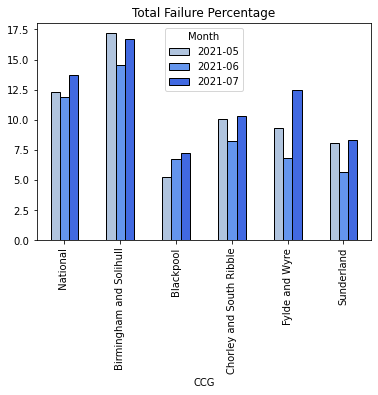

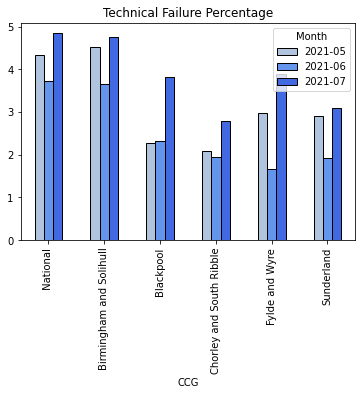

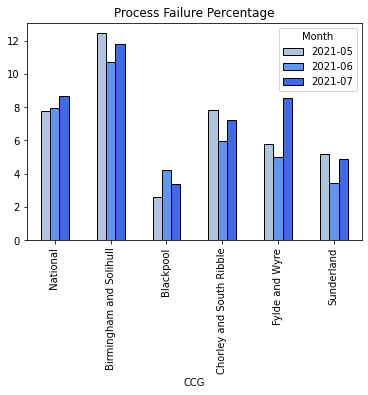

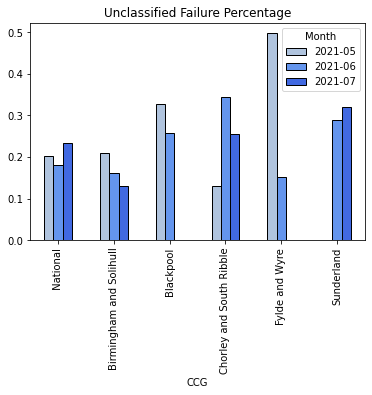

In [10]:
sending_grouped_by_ccg = group_transfers_by_ccg_and_month(sending_practice_lg_transfers)
sending_grouped = sending_grouped_by_ccg.set_index(['CCG', 'Month'])

colours=['lightsteelblue', 'cornflowerblue', 'royalblue']
sending_grouped.unstack().plot(kind='bar', y='Failure percentage', title='Total Failure Percentage', color=colours, edgecolor='black')
sending_grouped.unstack().plot(kind='bar', y='Technical failure percentage', title='Technical Failure Percentage', color=colours, edgecolor='black')
sending_grouped.unstack().plot(kind='bar', y='Process failure percentage', title='Process Failure Percentage', color=colours, edgecolor='black')
sending_grouped.unstack().plot(kind='bar', y='Unclassified failure percentage', title='Unclassified Failure Percentage', color=colours, edgecolor='black')

## Looking at failure rate trends by CCG when requesting a record

<AxesSubplot:title={'center':'Unclassified Failure Percentage'}, xlabel='CCG'>

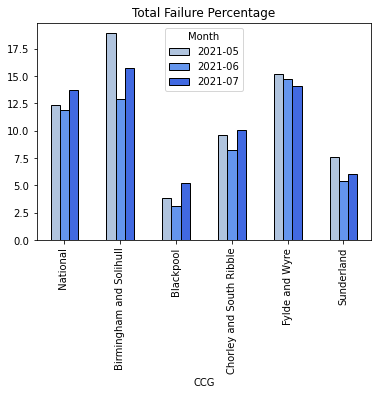

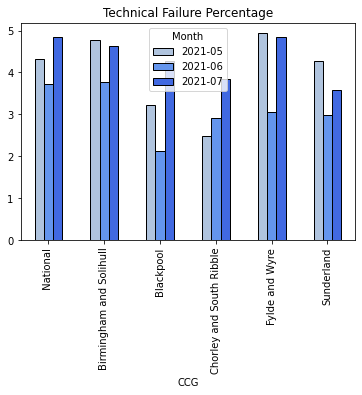

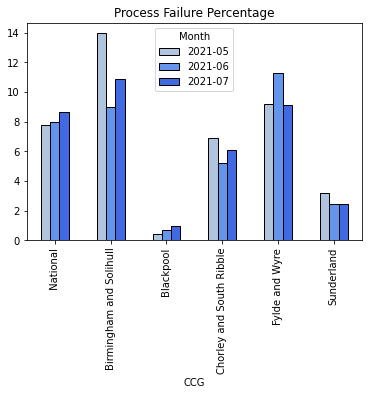

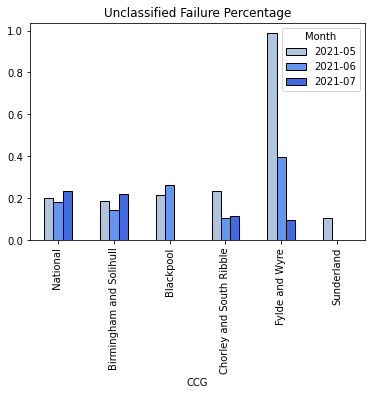

In [11]:
requesting_grouped_by_ccg = group_transfers_by_ccg_and_month(requesting_practice_lg_transfers)
requesting_grouped = requesting_grouped_by_ccg.set_index(['CCG', 'Month'])

colours=['lightsteelblue', 'cornflowerblue', 'royalblue']
requesting_grouped.unstack().plot(kind='bar', y='Failure percentage', title='Total Failure Percentage', color=colours, edgecolor='black')
requesting_grouped.unstack().plot(kind='bar', y='Technical failure percentage', title='Technical Failure Percentage', color=colours, edgecolor='black')
requesting_grouped.unstack().plot(kind='bar', y='Process failure percentage', title='Process Failure Percentage', color=colours, edgecolor='black')
requesting_grouped.unstack().plot(kind='bar', y='Unclassified failure percentage', title='Unclassified Failure Percentage', color=colours, edgecolor='black')

## Write CCG transfer outcomes by sending and requesting practice to Excel

In [12]:
with pd.ExcelWriter('PRMT-2332-Digitisation-Failure-Rates-May-July-2021.xlsx') as writer:
    sending_practice_lg_transfers.to_excel(writer, sheet_name="Sending",index=False)
    requesting_practice_lg_transfers.to_excel(writer, sheet_name="Requesting",index=False)